## SNR
The SNR-ratio can be defined by the following function:
\begin{equation}
    SNR = |V_{12}|^2 \cdot \alpha \cdot A \cdot \Phi \cdot \sqrt{\frac{T}{\Delta t}}
\end{equation}
where 
\begin{align}
    |V_{12}| &: \text{complex visiblity [unitless]} \\
    \alpha &: \text{efficiency  [unitless]} \\
    A &: \text{area in [m$^2$]} \\
    \Phi &: \text{spectral photon flux in [m$^{−2}$ s$^{−1}$ Hz$^{−1}$]} \\
    T &: \text{observation or integration time in [s] or [hrs]} \\
    \Delta t &: \text{time resolution in [s]}
\end{align}

In [68]:
import numpy as np
from brightstar_functions import Phi
from scipy.constants import c
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [69]:
# for the simple SNR
V_12 = 1
alpha = 0.125
diameter = 0.5 # m
delta_t = 3e-11 # s
wavelength = 540e-9 # m, bandwidth of V-mag
mag = 2

effective_diameter = 1

##################################################################################################################################

# for the case including optical and quantum efficiency, number of channels and background flux explicitly
efficiency_o = 0.5
efficiency_d = 0.25
B = 0
N_channel = 1

##################################################################################################################################

# for the case with two telescopes:
epsilon_O_1 = 0.5
epsilon_O_2 = 0.5
epsilon_D_1 = 0.25
epsilon_D_2 = 0.25

B_1 = 0
B_2 = 0

delta_t_1 = 3e-11
delta_t_2 = 3e-11

diameter_1 = 0.5 # m
diameter_2 = 0.5 # m
effective_diameter_1 = 1 # how much of the telescope area actually is used to collect photons
effective_diameter_2 = 1 # how much of the telescope area actually is used to collect photons

##################################################################################################################################

# including the widht of filter for the count rate and random coincidences
delta_lambda = 1e-9 # nm

##################################################################################################################################

# calculating effective areas:
def area_sub(diameter, effective_diameter):
    return np.pi*(diameter*effective_diameter/2)**2 #m^2


In [70]:
def SNR_simple(T, magnitude, diameter):
    return V_12**2*alpha*area_sub(diameter, effective_diameter)*Phi(magnitude, wavelength)*np.sqrt(T/delta_t)

print('SNR: ', SNR_simple(3600, mag, diameter))

SNR:  2.102894852175317


More explicitly we can express SNR as:
\begin{equation}
    SNR = |V_{12}|^2 \cdot \varepsilon_o \cdot \varepsilon_d \cdot \frac{A}{1+B/\Phi} \cdot \Phi \cdot \sqrt{\frac{T}{\Delta t}} \cdot \sqrt{N_\text{chan}}
\end{equation}
where we additionally have
\begin{align}
    \epsilon_o &: \text{optical efficiency [unitless]} \\
    \epsilon_d &: \text{detector or quantum efficiency [unitless]} \\
    B &: \text{background flux in [m$^{−2}$ s$^{−1}$ Hz$^{−1}$]} \\
    N_{chan} &: \text{number of channels [unitless]} \\
\end{align}

In [71]:
def SNR_(T, magnitude, diameter):
    efficiency = efficiency_o*efficiency_d
    Phi_ = Phi(magnitude, wavelength)
    area_ = area_sub(diameter, effective_diameter)/((1+B/Phi_))
    return V_12**2*area_*Phi_*np.sqrt(T/delta_t)*efficiency*np.sqrt(N_channel)

print('SNR: ', SNR_(3600, mag, diameter))

SNR:  2.102894852175317


For two telescopes of different diameters, efficiencies, background flux and time resolution we have:
\begin{align}
    SNR &= |V_{12}|^2 \cdot \sqrt{\varepsilon_{o,1}\varepsilon_{o,2}} \cdot \sqrt{\varepsilon_{d,1}\varepsilon_{d,2}} \cdot \sqrt{\frac{A_1A_2}{(1+B_1/\Phi)(1+B_2/\Phi)}}\cdot \Phi \cdot
    \sqrt{\frac{T}{\sqrt{\Delta t_1\Delta t_2}}} \cdot \sqrt{N_\text{chan}}
\end{align}

In [72]:
def SNR_two(T, magnitude, diameter1, diameter2, effective_diameter1, effective_diameter2):
    efficiency = np.sqrt(epsilon_O_1*epsilon_O_1)*np.sqrt(epsilon_D_1*epsilon_D_1)
    Phi_ = Phi(magnitude, wavelength)
    area_ = np.sqrt(area_sub(diameter1, effective_diameter1)*area_sub(diameter2, effective_diameter2)/((1+B_1/Phi_)*(1+B_2/Phi_)))
    return V_12**2*area_*Phi_*np.sqrt(T/np.sqrt(delta_t_1*delta_t_2))*efficiency*np.sqrt(N_channel)

print('SNR: ', SNR_two(3600, mag, diameter_1, diameter_2, effective_diameter_1, effective_diameter_2))

SNR:  2.102894852175317


We can also check the source count per second:
\begin{equation}
    N_\text{count} &= \varepsilon_o \cdot \epsilon_d \cdot \Phi \cdot \Delta \nu \cdot A\\
\end{equation}
with
\begin{align}
    \Delta \nu = \frac{c\cdot \Delta \lambda}{\lambda^2} \\
\end{align}

In [73]:
def count_rate(mag, diameter):
    Phi_ = Phi(mag, wavelength)
    delta_nu = c*delta_lambda/(wavelength**2)
    return efficiency_o*efficiency_d*delta_nu*Phi_*area_sub(diameter, effective_diameter)

print('count rate: ', count_rate(mag, diameter))

count rate:  197360.4460975257


## Random Coincidence Count
The random coincidence count (in other words, the baseline) per second is:
\begin{equation}
    N_\text{random} &= \varepsilon_o \cdot \epsilon_d \cdot \Phi \cdot \Delta \nu \cdot A\\
\end{equation}

In [65]:
def coincidences(T, magnitude, diameter):
    efficiency = efficiency_d*efficiency_o
    phi = Phi(magnitude, wavelength)
    delta_nu = c*delta_lambda/(wavelength**2)
    return ((area_sub(diameter, effective_diameter)*efficiency*phi*delta_nu)**2)*delta_t*T


print('coincidences in a hour for mag 2: ', coincidences(3600, mag, diameter))

coincidences in a hour for mag 2:  4206.723733851951


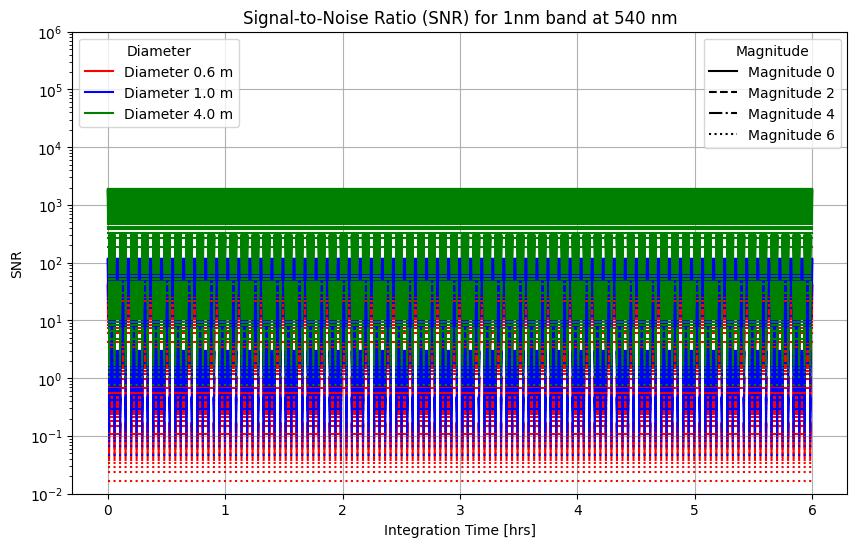

In [54]:
T_0 = np.linspace(0, 6, 100)
diameters = [0.6, 1.0, 4.0]
magnitudes = [0, 2, 4, 6]


# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 6))

colors = ['r', 'b', 'g']  # Different colors for different diameters
linestyles = ['-', '--', '-.', ':']  # Different linestyles for different magnitudes


for i, diameter_here in enumerate(diameters):
    for j, magnitude in enumerate(magnitudes):
        snr_values = [SNR_simple(T_0 * 3600, magnitude, diameter_here) for t in T_0]
        plt.plot(T_0, snr_values, color=colors[i], linestyle=linestyles[j], 
                 label=f'Diameter {diameter} m, Mag {magnitude}')
        
plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) for 1nm band at 540 nm')
diameter_legends = [mlines.Line2D([], [], color=colors[i], linestyle='-', label=f'Diameter {d} m')
                    for i, d in enumerate(diameters)]
magnitude_legends = [mlines.Line2D([], [], color='black', linestyle=linestyles[i], label=f'Magnitude {m}')
                     for i, m in enumerate(magnitudes)]

legend1 = plt.legend(handles=diameter_legends, loc='upper left', title="Diameter")
plt.gca().add_artist(legend1)  # Add the first legend manually
plt.legend(handles=magnitude_legends, loc='upper right', title="Magnitude")
plt.yscale("log")
plt.ylim(1e-2, 1e6)

plt.grid(True)
plt.show()